In [1]:
#make necesarry imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from math import sqrt
import sys, os
from contextlib import contextmanager
import matplotlib as mpl
import seaborn as sns
import sklearn

# I. Basic Time-Series Analyses

In [2]:
df = pd.read_csv('forecasting_data.csv', sep=',')
df.head()

,Period,Sales
0,1,5384
1,2,8081
2,3,10282
3,4,9156
4,5,6118


## 1. Visualize and interpret the pattern of this time-series

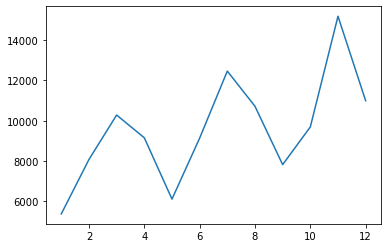

In [3]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(df["Period"], df["Sales"])
plt.show()

## 2. Predict future demand in month 13,14,15,16 without seasonality
* Using moving average, exponential smoothing.

### Using moving average

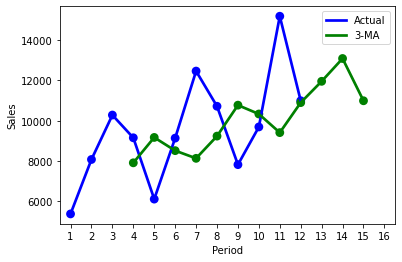

In [4]:
def moving_average(df, k, to_period):
    moving_average_df = pd.DataFrame(columns=['Period','Sales'])
    s = 0
    for i in range(k):
        new_row = {'Period': i+1, 'Sales': np.nan}
        moving_average_df.loc[i] = new_row
    
    while (to_period - k) >= 0:
        if k <= len(df):
            i = k-1
            s = (df["Sales"][i] + df["Sales"][i-1] + df["Sales"][i-2])/3
            new_row = {'Period': k+1, 'Sales': s}
            moving_average_df.loc[k] = new_row
            k += 1
      
        elif k == (len(df)+1): # k =13
            i = k-1 # i = 12
            s = (df["Sales"][i-1] + df["Sales"][i-2])/2
            new_row = {'Period': k+1, 'Sales': s}
            moving_average_df.loc[k] = new_row
            k += 1

        elif k == (len(df)+2): # k =14
            i = k-1 # i =13
            s = df["Sales"][i-2]
            new_row = {'Period': k+1, 'Sales': s}
            moving_average_df.loc[k] = new_row
            k += 1
        
        elif k >= (len(df)+2):
            new_row = {'Period': k+1, 'Sales': np.nan}
            moving_average_df.loc[k] = new_row
            break
        
    return moving_average_df
 
            
f, ax = plt.subplots(1, 1)
ma_df = moving_average(df, 3, 16)
sns.pointplot(x='Period', y='Sales', data=df, color='b')
sns.pointplot(x='Period', y='Sales', data=ma_df, color='g')
ax.legend(handles=ax.lines[::len(df)+1], labels=["Actual", "3-MA"])
plt.show()

### Using exponential smoothing

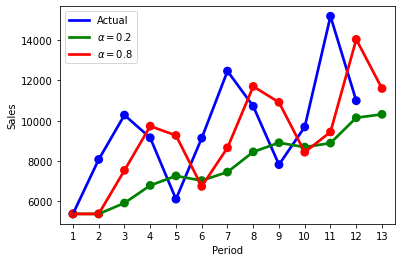

In [5]:
def exponential_smoothing(df, alpha):
    es_df = pd.DataFrame(columns=['Period','Sales'])
    i = 0
    while i <= len(df):
        if i <= 1:
            s = df["Sales"][0]
            new_row = {'Period': i+1, 'Sales': s}
            es_df.loc[i] = new_row
            i += 1
        else:
            s = alpha*df["Sales"][i-1] + (1-alpha)*es_df["Sales"][i-1]
            new_row = {'Period': i+1, 'Sales': s}
            es_df.loc[i] = new_row
            i += 1
    return es_df

f, ax = plt.subplots(1, 1)
es_df_02 = exponential_smoothing(df, 0.2)
es_df_08 = exponential_smoothing(df, 0.8)
sns.pointplot(ax=ax, x='Period', y='Sales', data=df, color='b')
sns.pointplot(ax=ax, x='Period', y='Sales', data=es_df_02, color='g')
sns.pointplot(ax=ax, x='Period', y='Sales', data=es_df_08, color='r')

ax.legend(handles=ax.lines[::len(df)+2], labels=["Actual", r'$\alpha=0.2$', r"$\alpha=0.8$"])
plt.show()

## 3. Predict future demand in month 13,14,15,16 with seasonality
Divide the time-series into 3 cycles (Month 1-4, 5-8, 9-12), then </p>
* Compute the average sales for each cycle </p>
* Compute the seasonal indices for each month of each cycle </p>
* Compute the seasonal indices for next cycle </p>
* Use linear regression on the average sales of cycles to predict the average sale for next cycle </p>
* Compute the seasonalize forecasts </p>

C:\Users\USER\AppData\Local\Temp\ipykernel_84980\1194866769.py:60: RankWarning: Polyfit may be poorly conditioned
  season_df = predict_with_seasonality(df, [13,14,15,16])


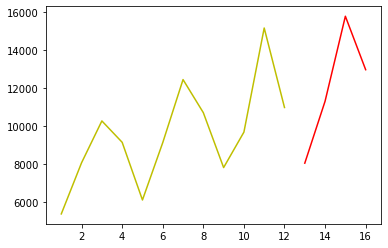

In [6]:
#season function
def get_season(row):
    if row['Period'] >= 5 and row['Period'] <= 8:
        return 'II'
    elif row['Period'] >= 9 and row['Period'] <= 12:
        return 'III'
    else:
        return 'I'
def get_seq(row):
    return row['Period']%4 and row['Period']%4 or 4

def predict_with_seasonality(df, months):
    new_df = df.copy()
    new_df['Season'] = new_df.apply(get_season, axis=1)
    new_df['Seq'] = new_df.apply(get_seq, axis=1)

    season_df = pd.DataFrame((new_df.pivot('Seq','Season')['Sales']).to_records())
    season_df.index = season_df['Seq']
    season_df = season_df.drop(['Seq'], axis=1)

    avg_df = pd.DataFrame(columns=['I','II','III'])
    avg_df['I'] = [season_df['I'].mean()]
    avg_df['II'] = [season_df['II'].mean()]
    avg_df['III'] = [season_df['III'].mean()]
    
    seasonal_index_df = pd.DataFrame(columns=['I','II','III'])
    seasonal_index_df['I'] = [season_df['I'][1]/avg_df['I'][0], season_df['I'][2]/avg_df['I'][0], 
                              season_df['I'][3]/avg_df['I'][0], season_df['I'][4]/avg_df['I'][0]]
    seasonal_index_df['II'] = [season_df['II'][1]/avg_df['II'][0], season_df['II'][2]/avg_df['II'][0], 
                               season_df['II'][3]/avg_df['II'][0], season_df['II'][4]/avg_df['II'][0]]
    seasonal_index_df['III'] = [season_df['III'][1]/avg_df['III'][0], 
                                season_df['III'][2]/avg_df['III'][0], 
                                season_df['III'][3]/avg_df['III'][0], 
                                season_df['III'][4]/avg_df['III'][0]]
    seasonal_index_df['Avg'] = [(seasonal_index_df['I'][0] + seasonal_index_df['II'][0] 
                                 + seasonal_index_df['III'][0])/3,
                               (seasonal_index_df['I'][1] + seasonal_index_df['II'][1] 
                                 + seasonal_index_df['III'][1])/3,
                               (seasonal_index_df['I'][2] + seasonal_index_df['II'][2] 
                                 + seasonal_index_df['III'][2])/3,
                               (seasonal_index_df['I'][3] + seasonal_index_df['II'][3] 
                                 + seasonal_index_df['III'][3])/3]
    
    season = np.array([1,2,3])
    avg_arr = np.array([avg_df['I'], avg_df['II'], avg_df['III']])
    fit = np.polyfit(season, avg_arr, 3)
    poly = np.poly1d(fit.reshape(-1))
    average_predict = poly(4)
    
    forecast_df = pd.DataFrame(columns=['Period','Sales'])
    forecast_df['Period'] = months
    forecast_df['Sales'] = [average_predict*seasonal_index_df['Avg'][0],
                            average_predict*seasonal_index_df['Avg'][1],
                            average_predict*seasonal_index_df['Avg'][2], 
                            average_predict*seasonal_index_df['Avg'][3]]
    forecast_df.index = np.array(months) - 1
    forecast_df
    return forecast_df

season_df = predict_with_seasonality(df, [13,14,15,16])

f, ax = plt.subplots(1, 1)
plt.plot(df['Period'], df['Sales'], c='y')
plt.plot(season_df['Period'], season_df['Sales'], c='r')
plt.show()

## 4. Evaluation: compare the above implemented methods
- Compute forecast errors
- Make conclusions

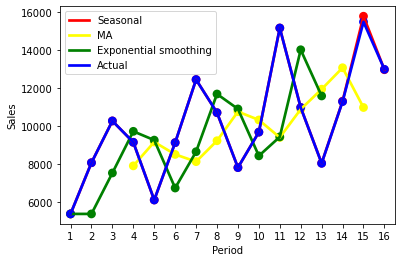

In [7]:
eval_df = pd.read_csv('forecasting_actual.csv')
eval_df = pd.concat([df, eval_df], ignore_index=True)

f, ax = plt.subplots(1, 1)
sns.pointplot(ax=ax, x='Period', y='Sales', data=pd.concat([df, season_df], ignore_index=True), color='r')
sns.pointplot(ax=ax, x='Period', y='Sales', data=ma_df, color='yellow')
sns.pointplot(ax=ax, x='Period', y='Sales', data=es_df_08, color='green')
sns.pointplot(ax=ax, x='Period', y='Sales', data=eval_df, color='b')
ax.legend(handles=ax.lines[::len(df)+5], labels=["Seasonal", 'MA', "Exponential smoothing", "Actual"])
plt.show()

In [8]:
MAD = np.abs(eval_df['Sales'][12:16] - moving_average(eval_df,3,16)['Sales'][12:16]).mean()
print("MAD of {0}: {1}".format("3-MA", MAD))
MAD = np.abs(eval_df['Sales'][12:16] - exponential_smoothing(eval_df, 0.2)['Sales'][12:16]).mean()
print("MAD of {0}: {1}".format("Exponential smoothing with alpha=0.2", MAD))
MAD = np.abs(eval_df['Sales'][12:16] - exponential_smoothing(eval_df, 0.8)['Sales'][12:16]).mean()
print("MAD of {0}: {1}".format("Exponential smoothing with alpha=0.8", MAD))
MAD = np.abs(eval_df['Sales'][12:16] - season_df['Sales']).mean()
print("MAD of {0}: {1}".format("Seasonality Method", MAD))

MAD of 3-MA: 2694.75
MAD of Exponential smoothing with alpha=0.2: 2707.7580143305513
MAD of Exponential smoothing with alpha=0.8: 3088.7232615120074
MAD of Seasonality Method: 85.88221407247443


In [9]:
MSE = np.square(np.subtract(eval_df['Sales'][12:16], moving_average(eval_df,3,16)['Sales'][12:16])).mean()
print("MSE of {0}: {1}".format("3-MA", MSE))
MSE = np.square(np.subtract(eval_df['Sales'][12:16], exponential_smoothing(eval_df, 0.2)['Sales'][12:16])).mean()
print("MSE of {0}: {1}".format("Exponential smoothing with alpha=0.2", MSE))
MSE = np.square(np.subtract(eval_df['Sales'][12:16], exponential_smoothing(eval_df, 0.8)['Sales'][12:16])).mean()
print("MSE of {0}: {1}".format("Exponential smoothing with alpha=0.8", MSE))
MSE = np.square(np.subtract(eval_df['Sales'][12:16], season_df['Sales'])).mean()
print("MSE of {0}: {1}".format("Seasonality Method", MSE))

MSE of 3-MA: 11544241.36111111
MSE of Exponential smoothing with alpha=0.2: 9744054.271861337
MSE of Exponential smoothing with alpha=0.8: 10909182.694821384
MSE of Seasonality Method: 22206.08964632366


#### conclusions
Seasonality Method has the best performance (the lowest MAD and MSE value).

---

# II. Time-Series Analyses for Electricity Consumption

## 1. Electricity Consumption Exploration
Use the provided Jupyter notebook. </p> </p>
In this exercise, you will be asked to explore time series data in several ways. </p>
You will be working with time series of Open Power System Data (OPSD) for Germany. </p>
The data set includes daily electricity consumption, wind power production, and solar power
production between 2006 and 2017.
- Date — The date (yyyy-mm-dd format)
- Consumption — Electricity consumption in GWh
- Wind — Wind power production in GWh
- Solar — Solar power production in GWh
- Wind+Solar — Sum of wind and solar power production in GWh

Tasks: </p>
-  Plotting and understanding a time series
-  Change the scale
-  Further exploration
-  Fill missing values
-  Series correlation

In [10]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

In [11]:
# Load file
df = pd.read_csv('opsd_germany_daily.csv', sep=',', index_col='Date')
df.head()

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-01,1069.184,NaN,NaN,NaN
2006-01-02,1380.521,NaN,NaN,NaN
2006-01-03,1442.533,NaN,NaN,NaN
2006-01-04,1457.217,NaN,NaN,NaN
2006-01-05,1477.131,NaN,NaN,NaN


In [12]:
# Description
df.describe()

,Consumption,Wind,Solar,Wind+Solar
count,4383.000000,2920.000000,2188.000000,2187.000000
mean,1338.675836,164.814173,89.258695,272.663481
std,165.775710,143.692732,58.550099,146.319884
min,842.395000,5.757000,1.968000,21.478000
25%,1217.859000,62.353250,35.179250,172.185500
50%,1367.123000,119.098000,86.407000,240.991000
75%,1457.761000,217.900250,135.071500,338.988000
max,1709.568000,826.278000,241.580000,851.556000


#### transform the dates into datetime format in pandas :

In [13]:
# Transform the dates into datetime format
df.index = pd.to_datetime(df.index)

type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

### 1. Plotting and understanding a time series

Q1 - Plot the different time series. What do you understand, what do you notice ?
- seasonal pattern
- consumption higher than production (wind and solar)
- no production data before 2012

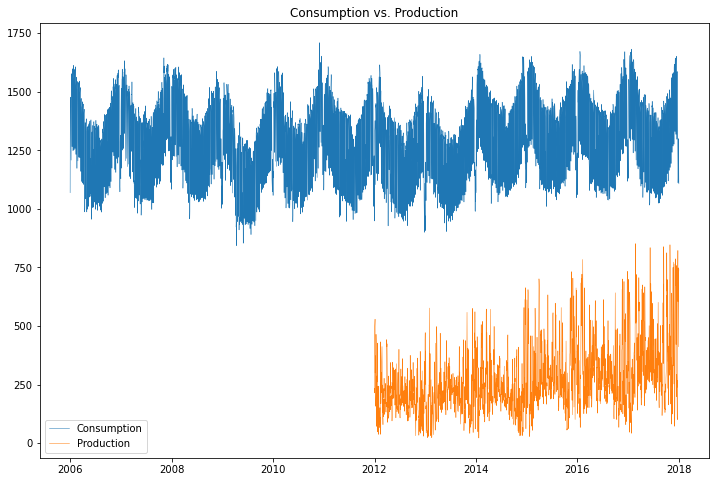

In [14]:
plt.figure(figsize=(12,8))
plt.plot(df.index, df["Consumption"], lw=0.5)
plt.plot(df.index, df["Wind+Solar"], lw=0.5)
plt.title('Consumption vs. Production')
plt.legend(['Consumption', 'Production'])
plt.show()

#### simply plot dots for the consumption :

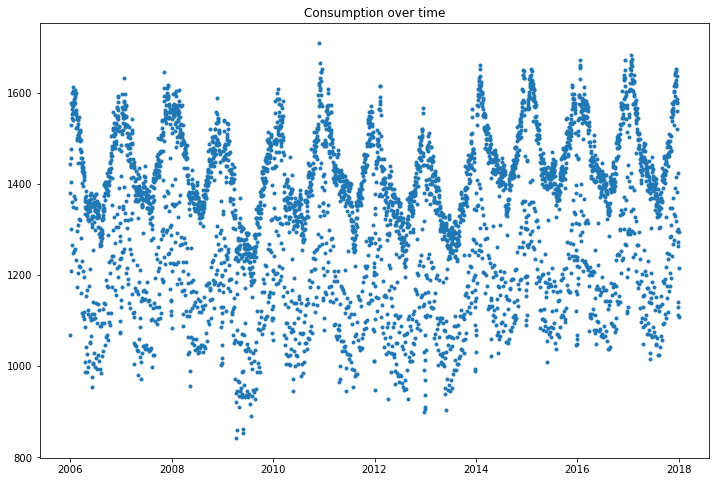

In [15]:
plt.figure(figsize=(12,8))
plt.scatter(df.index, df["Consumption"], s=9)
plt.title('Consumption over time')
plt.show()

#### plot the production over time :

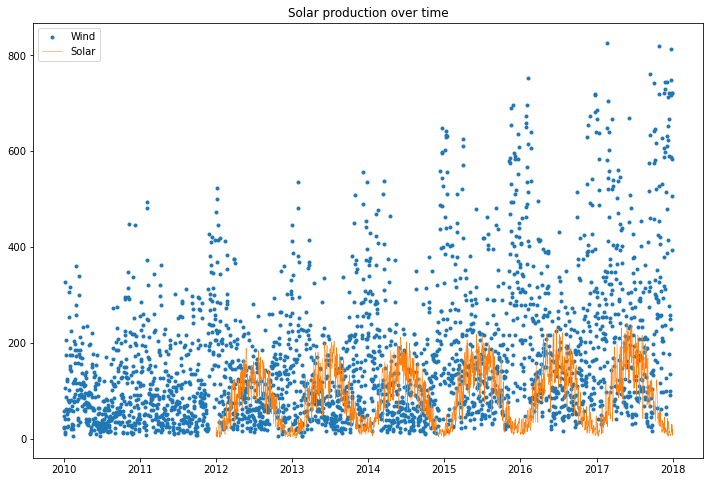

In [16]:
plt.figure(figsize=(12,8))
plt.scatter(df.index, df["Wind"], s=9)
plt.plot(df.index, df["Solar"], lw=0.5, color='tab:orange')
plt.title('Solar production over time')
plt.legend(['Wind', 'Solar'])
plt.show()

#### consumption and production compare

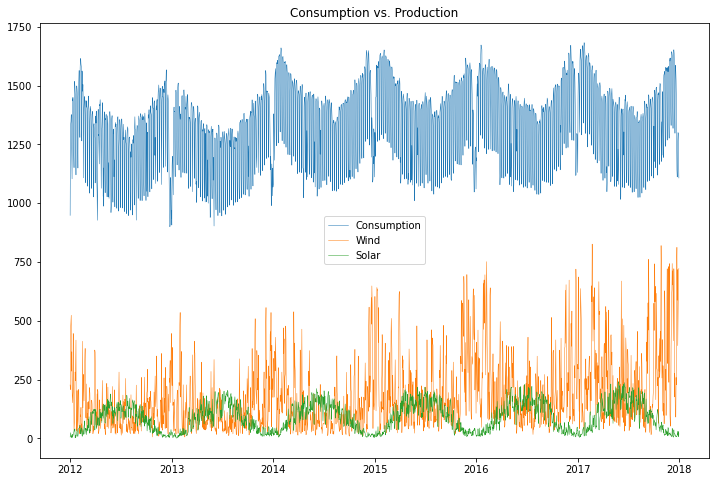

In [17]:
plt.figure(figsize=(12,8))
df2 = df.loc['20120101':]
plt.plot(df2.index, df2["Consumption"], lw=0.5)
plt.plot(df2.index, df2["Wind"], lw=0.5)
plt.plot(df2.index, df2["Solar"], lw=0.5)
plt.title('Consumption vs. Production')
plt.legend(['Consumption', 'Wind', 'Solar'])

plt.show()

### 2. Change the scale

Q2 - Try to change the scale to understand the recurrent patterns !

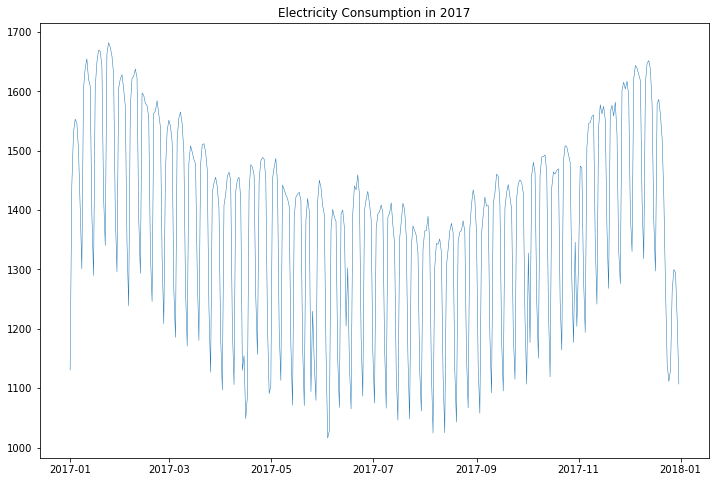

In [18]:
# Plot over the year
plt.figure(figsize=(12,8))
df_2017 = df.loc['20170101':'20171231']
plt.plot(df_2017.index, df_2017["Consumption"], lw=0.5)
plt.title('Electricity Consumption in 2017')
plt.show()

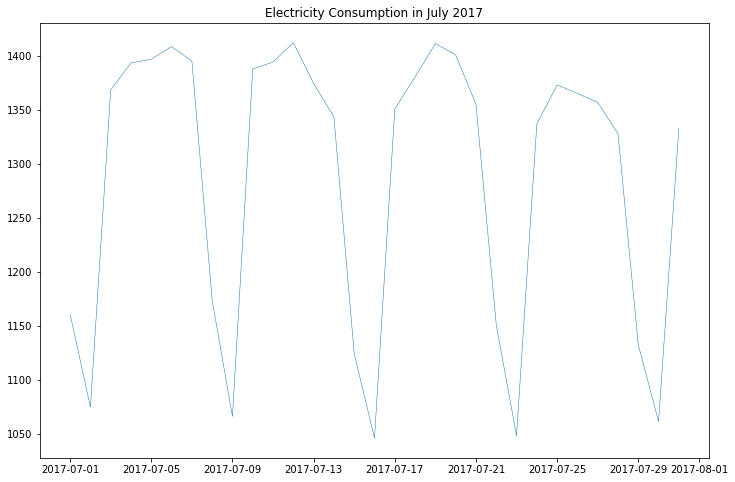

In [19]:
# Plot over a month
plt.figure(figsize=(12,8))
df_201707 = df.loc['20170701':'20170731']
plt.plot(df_201707.index, df_201707["Consumption"], lw=0.5)
plt.title('Electricity Consumption in July 2017')
plt.show()

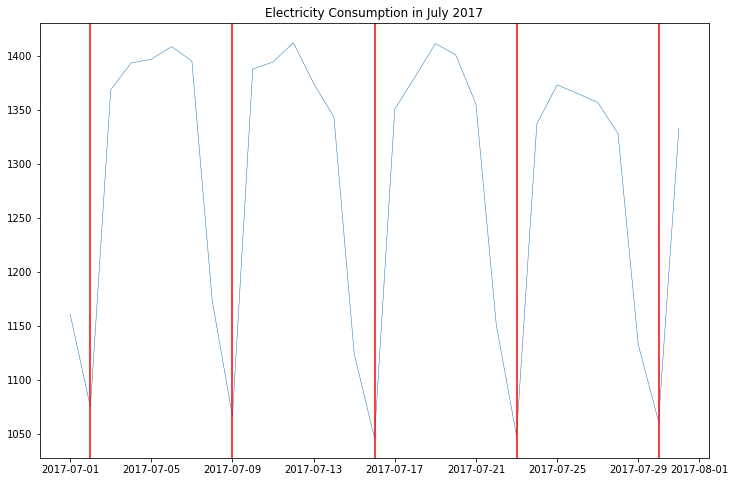

In [20]:
# Plot on Sundays
import datetime as dt

plt.figure(figsize=(12,8))
df_201707 = df.loc['20170701':'20170731']
plt.plot(df_201707.index, df_201707["Consumption"], lw=0.5)
#sunday = ['2017-07-02', '2017-07-09', '2017-07-16', '2017-07-23',
#               '2017-07-30']
#x = [dt.datetime(2017,7,2), dt.datetime(2017,7,9), dt.datetime(2017,7,16), dt.datetime(2017,7,23),
#    dt.datetime(2017,7,30)]

# found Sundays
Sundays = df_201707.iloc[(df_201707.index.dayofweek == 6)].index.strftime('%y-%m-%d')

# highlight Sundays
for i in range(len(Sundays)):
    date = dt.datetime.strptime(Sundays[i], '%y-%m-%d')
    plt.axvline(date, color = 'r')

plt.title('Electricity Consumption in July 2017')
plt.show()

### 3. Further exploration

Q3 - To further explore the dataset, we might need to group the data. Create new columns for the consumption (by year and month), and create box-plots with seaborn. Comment on your results.

In [21]:
# new columns 'year' and 'month'
df_2 = df.reset_index()
df_2['year'] = df.index.year
df_2['month'] = df.index.strftime("%b")
years = df_2['year'].unique()
print(years)
df_2.head()

[2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017]


,Date,Consumption,Wind,Solar,Wind+Solar,year,month
0,2006-01-01,1069.184,NaN,NaN,NaN,2006,Jan
1,2006-01-02,1380.521,NaN,NaN,NaN,2006,Jan
2,2006-01-03,1442.533,NaN,NaN,NaN,2006,Jan
3,2006-01-04,1457.217,NaN,NaN,NaN,2006,Jan
4,2006-01-05,1477.131,NaN,NaN,NaN,2006,Jan


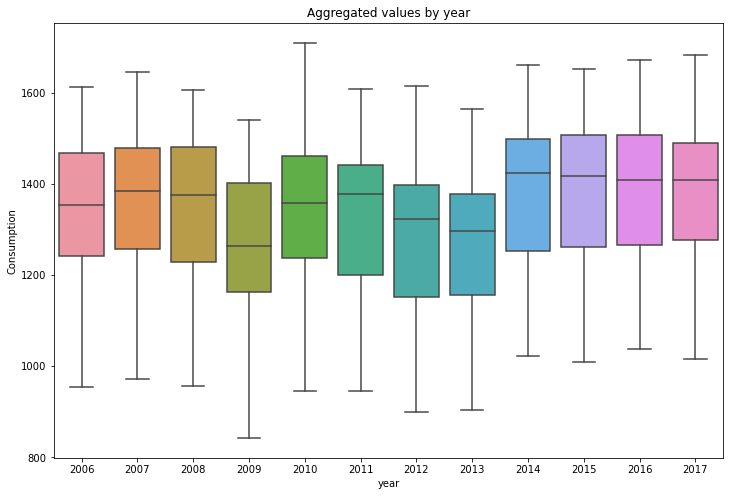

In [22]:
# Boxplot year
import seaborn as sns
plt.figure(figsize=(12,8))
sns.boxplot(data = df_2, x='year', y='Consumption')
plt.title('Aggregated values by year')
plt.show()

- 2009 has the lowest median; 2014 has the highset median
- 2014 - 2017 has a similar plot

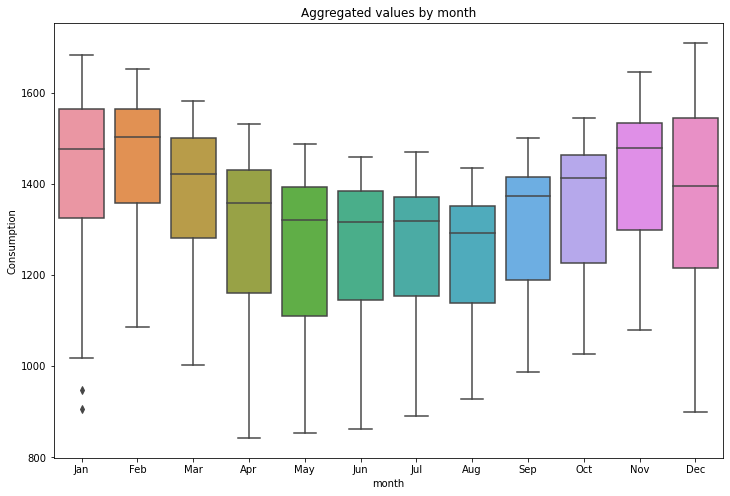

In [23]:
# Boxplot month
import seaborn as sns
plt.figure(figsize=(12,8))
sns.boxplot(data = df_2, x='month', y='Consumption')
plt.title('Aggregated values by month')
plt.show()

- January has outliers 
- December has the highest interquartile range 
- August has the lowest median; February has the highest median

### 4. Fill missing values

Q4 - Do you face missing values in production ? If yes, which method can you apply ? What happens if you plot the modified data ? It is a good idea to keep the data this way ? </p></p>
Yes, production values before 2012 are missing. The backfill method can be applied. The modified data will be plotted in the graph.

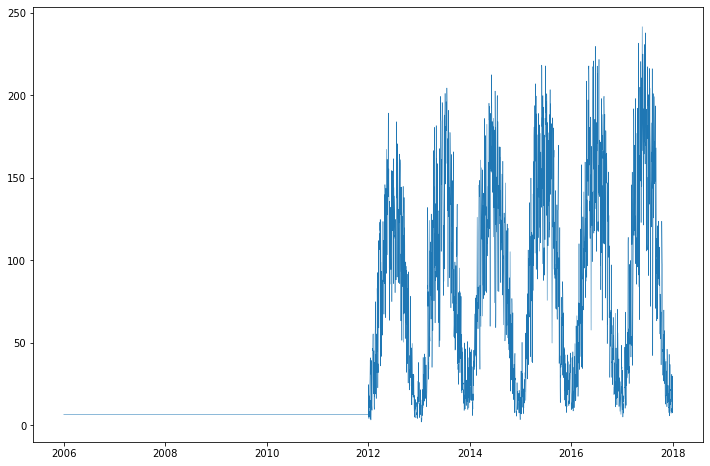

In [24]:
# Plot Solar
plt.figure(figsize=(12,8))
df_3 = df.copy()
df_3["Solar"] = df_3["Solar"].fillna(method='backfill')
plt.plot(df_3.index, df_3["Solar"], lw=0.5)
plt.show()

### 5. Series correlation

Q5 - A good way to explore time series, when you have several series, is to plot one series vs another. This is a good way to estimate the correlation between 2 series. Plot the relevant graphs (and compute the correlation) for wind + solar vs consumption, wind vs solar, wind vs consumption, and solar vs consumption.

In [25]:
# Correlation between consumption and overall production
df['Consumption'].corr(df['Wind+Solar'])

0.02764784385924092

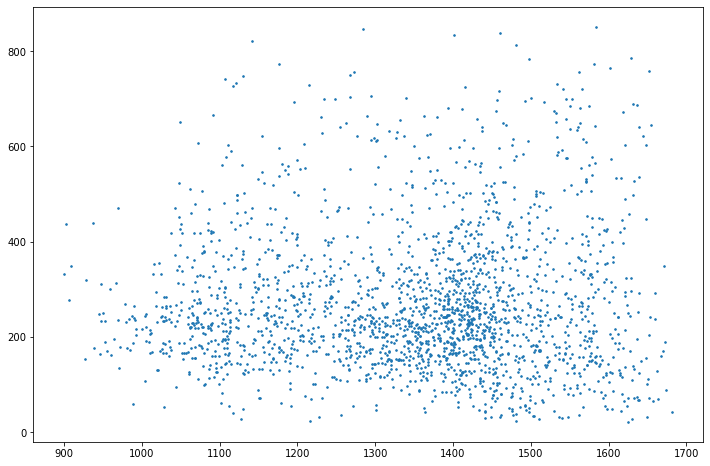

In [26]:
# Plot
plt.figure(figsize=(12,8))
plt.scatter(df['Consumption'], df['Wind+Solar'], s=2.5)
plt.show()

In [27]:
# Correlation between solar production and wind production
df['Solar'].corr(df['Wind'])

-0.3088318295977341

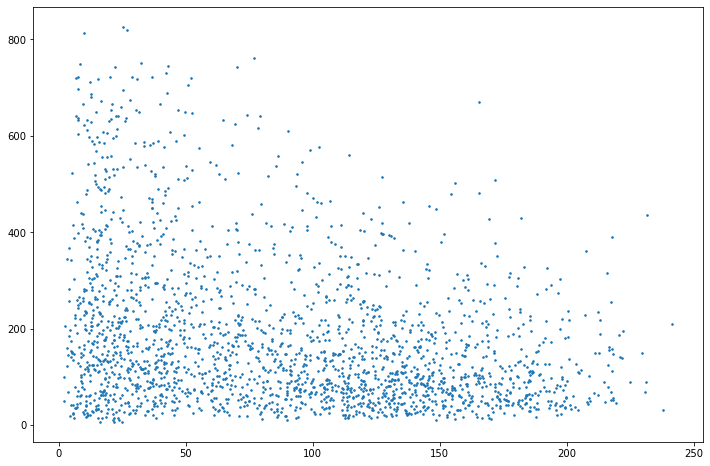

In [28]:
# Plot
plt.figure(figsize=(12,8))
plt.scatter(df['Solar'], df['Wind'], s=2.5)
plt.show()

In [29]:
# Correlation between consumption and wind production
df['Consumption'].corr(df['Wind'])

0.13682075809765853

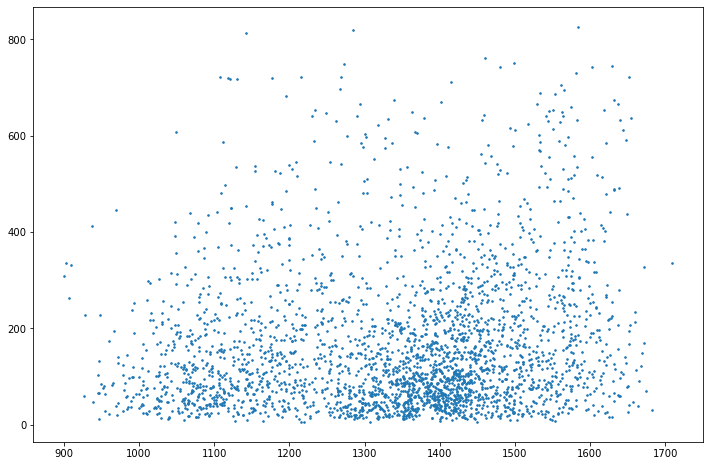

In [30]:
# Plot
plt.figure(figsize=(12,8))
plt.scatter(df['Consumption'], df['Wind'], s=2.5)
plt.show()

In [31]:
# Correlation between consumption and solar production
df['Consumption'].corr(df['Solar'])

-0.27894265519914385

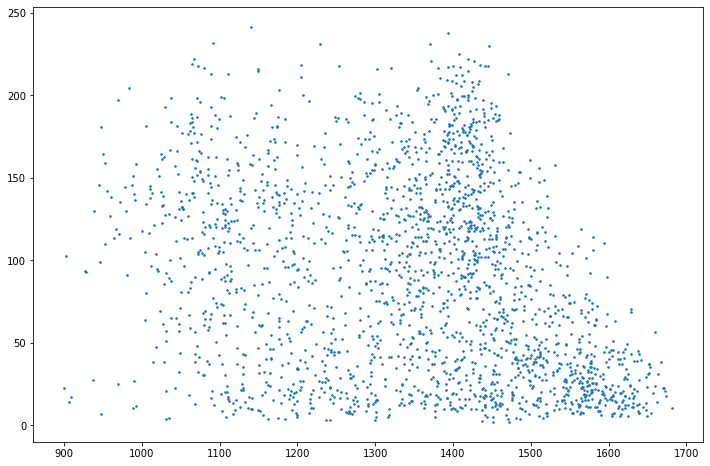

In [32]:
# Plot
plt.figure(figsize=(12,8))
plt.scatter(df['Consumption'], df['Solar'], s=2.5)
plt.show()

---

## 2. Electricity Consumption Prediction (OPTIONAL)
Use the provided Jupyter notebook.</p>
In this exercise, you will be asked to use insights from the previous exploration and build forecasts
for the electricity consumption.</p>
You will be working with time series of Open Power System Data (OPSD) for Germany.</p>
The data set includes daily electricity consumption, wind power production, and solar power
production between 2006 and 2017.</p>
- Date — The date (yyyy-mm-dd format)
- Consumption — Electricity consumption in GWh
- Wind — Wind power production in GWh
- Solar — Solar power production in GWh
- Wind+Solar — Sum of wind and solar power production in GWh

Tasks:</p>
- Key concepts in time series
- Trends
- Seasonality
- Automatic decomposition
- MA processes
- AR processes
- ARMA process
- ARIMA process
- SARIMA process